# EMNIST on Colab
- [데이콘 컴퓨터 비전 학습 경진대회](https://dacon.io/competitions/official/235626)를 코랩에서 풀어보았습니다.
- [다운로드 페이지](https://dacon.io/competitions/official/235626/data/)에서 다운로드 받은 `zip` 파일을 그대로 업로드 하는 것부터 시작합니다.

## Import Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

from keras import layers
from keras import models

## 데이터 업로드 하기

In [ ]:
from google.colab import files
files.upload() # data.zip 업로드

In [ ]:
! unzip data.zip

In [5]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
submission = pd.read_csv("submission.csv", index_col=0)

## 데이터 들여다보기

In [6]:
print(train.shape)
train.head()

(2048, 786)


,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,1,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,2,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,1,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,4,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,2,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [7]:
print(test.shape)
test.head()

(20480, 785)


,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,4,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,3,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,1,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,3,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4


특정 알파벳으로 가려진 숫자가 무엇인지 맞추는 문제입니다.

가리는 데 사용된 문자(letter)가 무엇인지를 맨 처음에 알려주고, 28*28 이미지가 주어지네요.

이미지가 어떻게 생겼나 볼까요?

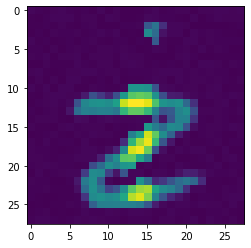

Letter: Z
Number: 1


In [8]:
import random
ranid = random.randint(0, 2048)

img = np.array(train.iloc[ranid, 2:]).reshape(28, 28).astype(np.float)
plt.imshow(img)
plt.show()
print('Letter:', train.iloc[ranid]['letter'])
print('Number:', train.iloc[ranid]['digit'])

숫자가 어딨는지 모르겠지만... 딥러닝은 우리보다 똑똑합니다. 한번 해보죠!

## 데이터 전처리하기

우선, train 데이터를 x와 y로 나눠줍니다.

In [9]:
x_train = np.array(train.iloc[:, 2:]).reshape(-1, 28, 28, 1).astype(np.float)
y_train = to_categorical(train['digit'].values)

print(x_train.shape)
print(y_train.shape)

(2048, 28, 28, 1)
(2048, 10)


Train set에서 Validation Set을 조금 때어내 줍니다.

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)
print(x_train.shape[0])
print(x_val.shape[0])

1843
205


### 데이터 증식
Keras의 갓갓 Generator를 활용하면 쉽게 데이터를 증식시킬 수 있습니다.

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./4, # 값 범위가 0~255가 아니라 0~4이므로 4로 나눠주면 됩니다..
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    )
test_datagen = test_datagen = ImageDataGenerator(rescale=1./4)

## ConvNet 구성

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=3, activation='relu',
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [13]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## 학습

In [14]:
batch = 32
epoch = 100

In [15]:
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=x_train.shape[0]//batch, # 전체 데이터 수 / 배치 사이즈
    epochs=epoch,
    validation_data=test_datagen.flow(x_val, y_val),
    verbose=0,
)

### 결과 시각화

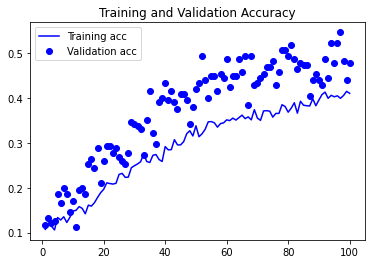

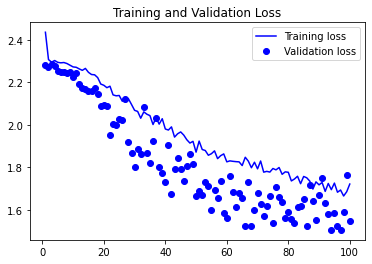

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## 예측

In [17]:
x_test = np.array(test.iloc[:, 1:]).reshape(-1, 28, 28, 1).astype(np.float)
x_test /= 4.
print(x_test.shape)
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
print(pred.shape)

(20480, 28, 28, 1)
(20480,)


In [18]:
print(pred[:5])

[8 9 2 0 3]


### 예측 시각화

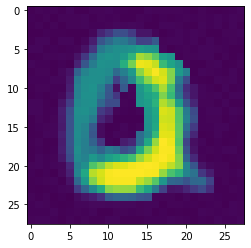

Prediction: 8


In [19]:
ranid = random.randint(0, 20480)

img = np.array(test.iloc[ranid, 1:]).reshape(28, 28).astype(np.float)
plt.imshow(img)
plt.show()
print('Prediction:', pred[ranid])

## Submission

In [20]:
submission.digit = pred
submission.head()

,digit
id,
2049,8
2050,9
2051,2
2052,0
2053,3


In [21]:
submission.to_csv('my_submission.csv') # Accuracy: 0.53921

## Conclusion
- 개선 가능점
    - ConvNet 파라메터 수정 (Pooling 안하는 방향으로)
    - letter 파라메터 사용
- 하고싶은 말
    - 사실 다른 Task에 쓰던 ConvNet을 그대로 가져와서.. 성능이 그닥 높지 않습니다 ㅋㅋ
    - Colab에 데이터 불러오는 방법이 복잡할 것 같아서 만들어 본 노트북인데 생각보다 쉽네요.
    - 그냥 초보자의 귀여운 시도로 봐주시면 감사하겠습니당!